# Experiment of Housing prices dataset

Obtained from: 
https://my.spindices.com/indices/real-estate/sp-corelogic-case-shiller-20-city-composite-home-price-nsa-index

In [1]:
# execute if not installed
import sys
sys.path.insert(0, '../')

import mogptk

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

%reload_ext autoreload
%autoreload 2

In [2]:
# plot config
sns.set_context('paper', font_scale=1.3)
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = (10, 5)

In [3]:
def test_errors(model):
    """
    Obtain test errors for model
    
    The function assumes the original data includes the test data
    """
    x_pred = {i:array[stop:] for i, array in enumerate(model.data.X_all)}
    
    y_pred, var_pred = model.predict(x_pred)
    
    n_channels = model.data.get_output_dims()
    
    mae = np.zeros(n_channels)
    mape = np.zeros(n_channels)
    mse = np.zeros(n_channels)
    
    for i in range(n_channels):
        idx = model.data.Y_all[i] != 0
        y_true = model.data.Y_all[i][stop:]
        
        mae[i] = np.abs(y_true - y_pred[i]).mean()
        mape[i] = np.abs((y_true - y_pred[i]) / y_true).mean()
        mse[i] = ((y_true - y_pred[i])**2).mean()
    return mae, mape, mse

In [4]:
def plot_experiment(model, ylims=None, names=[], trends=None, title='Finance experiment'):
    """
    Plot finance exchange mogptk experiment
    """
    x_train = model.data.X
    y_train = model.data.Y
    x_all = model.data.X_all
    y_all = model.data.Y_all
    x_pred = {i:array for i, array in enumerate(data.X_all)}

    mean_pred, var_pred = model.predict(x_pred)
    
    f, axarr = plt.subplots(3, 2, sharex=True, figsize=(20, 15))
    axarr = axarr.reshape(-1)
    
    if trends is None:
    
        for i in range(len(x_train)):
            axarr[i].plot(x_train[i][:, 0], y_train[i], '.k', label='Train', )
            axarr[i].plot(x_all[i][:, 0], y_all[i], '--', label='Test', c='gray')

            axarr[i].plot(x_pred[i][:, 0], mean_pred[i], label='Pred', c=sns.color_palette()[i%10])
            axarr[i].fill_between(x_pred[i][:, 0].reshape(-1),
                                  mean_pred[i] + 2 * np.sqrt(var_pred[i]),
                                  mean_pred[i] - 2 * np.sqrt(var_pred[i]),
                                  label='95% c.i',
                                  color=sns.color_palette()[i%10],
                                  alpha=0.4)

            axarr[i].legend(ncol=4)
            axarr[i].set_title(names[i])
            axarr[i].set_xlim(-1, x_all[i][-1])
    else:
        for i in range(len(x_train)):
            t = np.polyval(trends[i], x_train[i][:, 0].reshape(-1))
            axarr[i].plot(x_train[i][:, 0], y_train[i] + t,'.k', label='Train', )
            
            t = np.polyval(trends[i], x_all[i][:, 0].reshape(-1))
            axarr[i].plot(x_all[i][:, 0], y_all[i] + t, '--', label='Test', c='gray')

            t = np.polyval(trends[i], x_pred[i][:, 0].reshape(-1))
            axarr[i].plot(x_pred[i][:, 0], mean_pred[i] + t, label='Pred', c=sns.color_palette()[i%10])
            axarr[i].fill_between(x_pred[i][:, 0].reshape(-1),
                                  mean_pred[i]  + t + 2 * np.sqrt(var_pred[i]),
                                  mean_pred[i] + t - 2 * np.sqrt(var_pred[i]),
                                  label='95% c.i',
                                  color=sns.color_palette()[i%10],
                                  alpha=0.4)

            axarr[i].legend(ncol=4)
            axarr[i].set_title(names[i])
            axarr[i].set_xlim(-1, x_all[i][-1])
        
    plt.suptitle(title, y=1.02)
    plt.tight_layout()

### Load dataset

In [5]:
# load dataset 
cols = ['Chicago', 'Phoenix', 'Los Angeles', 'San Diego', 'New York', 'San Francisco']

df = pd.read_csv('data/finance_datasets/housing_prices_usa/housing_dataset.csv',
                 skiprows=7,
                 names=cols)
df = df.iloc[:-4]
df.index = pd.to_datetime(df.index)

df['Month'] = np.round(((df.index - df.index[0]) / np.timedelta64(1, 'M')).values)
df.head()

,Chicago,Phoenix,Los Angeles,San Diego,New York,San Francisco,Month
2009-05-01,123.73,103.56,159.18,145.06,171.17,120.16,0.0
2009-06-01,124.99,104.73,160.90,147.31,172.34,124.70,1.0
2009-07-01,128.32,106.66,163.97,150.99,173.91,128.86,2.0
2009-08-01,130.55,108.41,166.62,153.34,175.13,132.47,3.0
2009-09-01,132.13,109.26,168.03,154.76,174.81,134.16,4.0


### Data

In [6]:
data = mogptk.Data()

trend_list = []

for i, c in enumerate(cols):
    x = df['Month'].values
    y_old = df[c].values
    # y = np.log(df[c].values)
    
    # detrend 
    pol = np.polyfit(x, y_old, 1)
    trend_list.append(pol)
    y = y_old - np.polyval(pol, x)
    
    data.add(x.reshape(-1, 1), y)
    
    stop = int(len(df) * 0.9)
    data.remove_range(i, df['Month'][stop], None)

### Model 

In [26]:
n_trials = 10

mosm_mae = np.zeros((n_trials, len(cols)))
mosm_mape = np.zeros((n_trials, len(cols)))
mosm_mse = np.zeros((n_trials, len(cols)))

for n in range(n_trials):
    print('Trial ', n)
    model = mogptk.MOSM(data, Q=3)
    # model.init_params('means')
    
    model.train(method='L-BFGS-B', maxiter=3000, tol=1e-50)
    
    mae, mape, mse = test_errors(model)
    
    mosm_mae[n, :] = mae
    mosm_mape[n, :] = mape
    mosm_mse[n, :] = mse

pd.DataFrame(np.c_[mosm_mae.mean(0), mosm_mape.mean(0), mosm_mse.mean(0),
                             mosm_mae.std(0), mosm_mape.std(0), mosm_mse.std(0)],
                       columns=['MAE', 'MAPE%', 'MSE', 'MAE std', 'MAPE% std', 'MSE std'])

Trial  0
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 653.189389
  Number of iterations: 3000
  Number of functions evaluations: 3264
Done in  6.8061487674713135  minutes
Trial  1
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 648.834436
  Number of iterations: 3000
  Number of functions evaluations: 3241
Done in  6.756497383117676  minutes
Trial  2
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 656.996558
  Number of iterations: 3000
  Number of functions evaluations: 3231
Done in  6.792500285307566  minutes
Trial  3
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 658.802623
  Number of iterations: 3000
  Number of functions evaluations: 3258
Done in

,MAE,MAPE%,MSE,MAE std,MAPE% std,MSE std
0,3.461063,1.702307,20.599236,2.291141,1.182195,23.296335
1,1.959832,1.355500,9.016037,1.602733,1.196819,15.842688
2,2.044010,1.078500,7.694064,0.963794,0.459127,7.614428
3,2.915703,10.651766,14.951043,1.422476,6.935756,13.769858
4,5.209289,0.831203,38.114072,1.928190,0.288190,25.766213
5,4.563608,1.233232,37.178968,2.361947,0.787164,34.784468


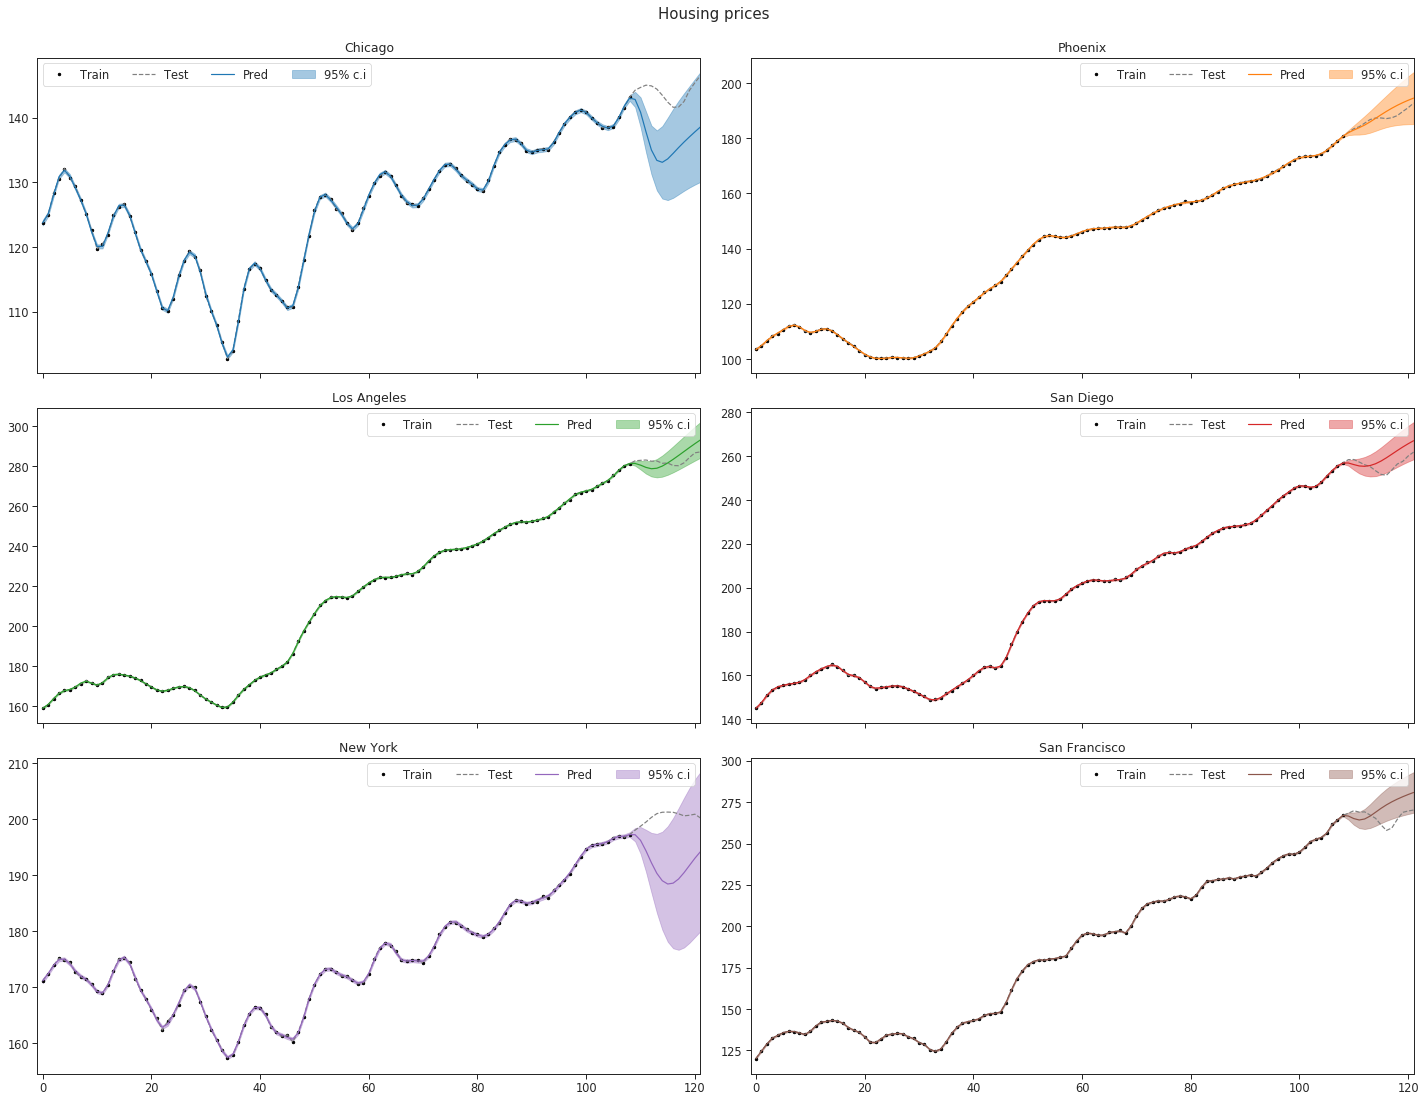

In [27]:
plot_experiment(model, names=cols, trends=trend_list, title='Housing prices')

## CSM

In [15]:
n_trials = 10

csm_mae = np.zeros((n_trials, len(cols)))
csm_mape = np.zeros((n_trials, len(cols)))
csm_mse = np.zeros((n_trials, len(cols)))

for n in range(n_trials):
    print('Trial ', n)
    model = mogptk.CSM(data, Q=3)
    # model.init_params()
    
    model.train(method='L-BFGS-B', maxiter=3000, tol=1e-50)
    
    mae, mape, mse = test_errors(model)
    
    csm_mae[n, :] = mae
    csm_mape[n, :] = mape
    csm_mse[n, :] = mse

pd.DataFrame(np.c_[csm_mae.mean(0), csm_mape.mean(0), csm_mse.mean(0),
                             csm_mae.std(0), csm_mape.std(0), csm_mse.std(0)],
                       columns=['MAE', 'MAPE%', 'MSE', 'MAE std', 'MAPE% std', 'MSE std'])

Trial  0
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 1217.006709
  Number of iterations: 3000
  Number of functions evaluations: 3271
Done in  2.876550642649333  minutes
Trial  1
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 1219.919156
  Number of iterations: 1688
  Number of functions evaluations: 1873
Done in  1.9239044427871703  minutes
Trial  2
INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: 1213.147106
  Number of iterations: 2539
  Number of functions evaluations: 2814
Done in  2.631945093472799  minutes
Trial  3
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 1217.305871
  Number of iterations: 3000
  Number of functions evaluations: 3280
Done in  2.9

,MAE,MAPE%,MSE,MAE std,MAPE% std,MSE std
0,1.097435,0.483813,2.756603,0.166370,0.072049,0.681374
1,1.673257,0.845801,3.320728,0.276410,0.126759,0.858628
2,3.885395,2.241357,16.756993,0.430367,0.286794,3.764706
3,3.705788,3.767602,19.650221,0.394004,2.034979,3.577628
4,3.645133,0.592951,17.323082,0.442150,0.068724,4.131324
5,3.896462,1.017707,27.197645,0.434975,0.153649,5.001486


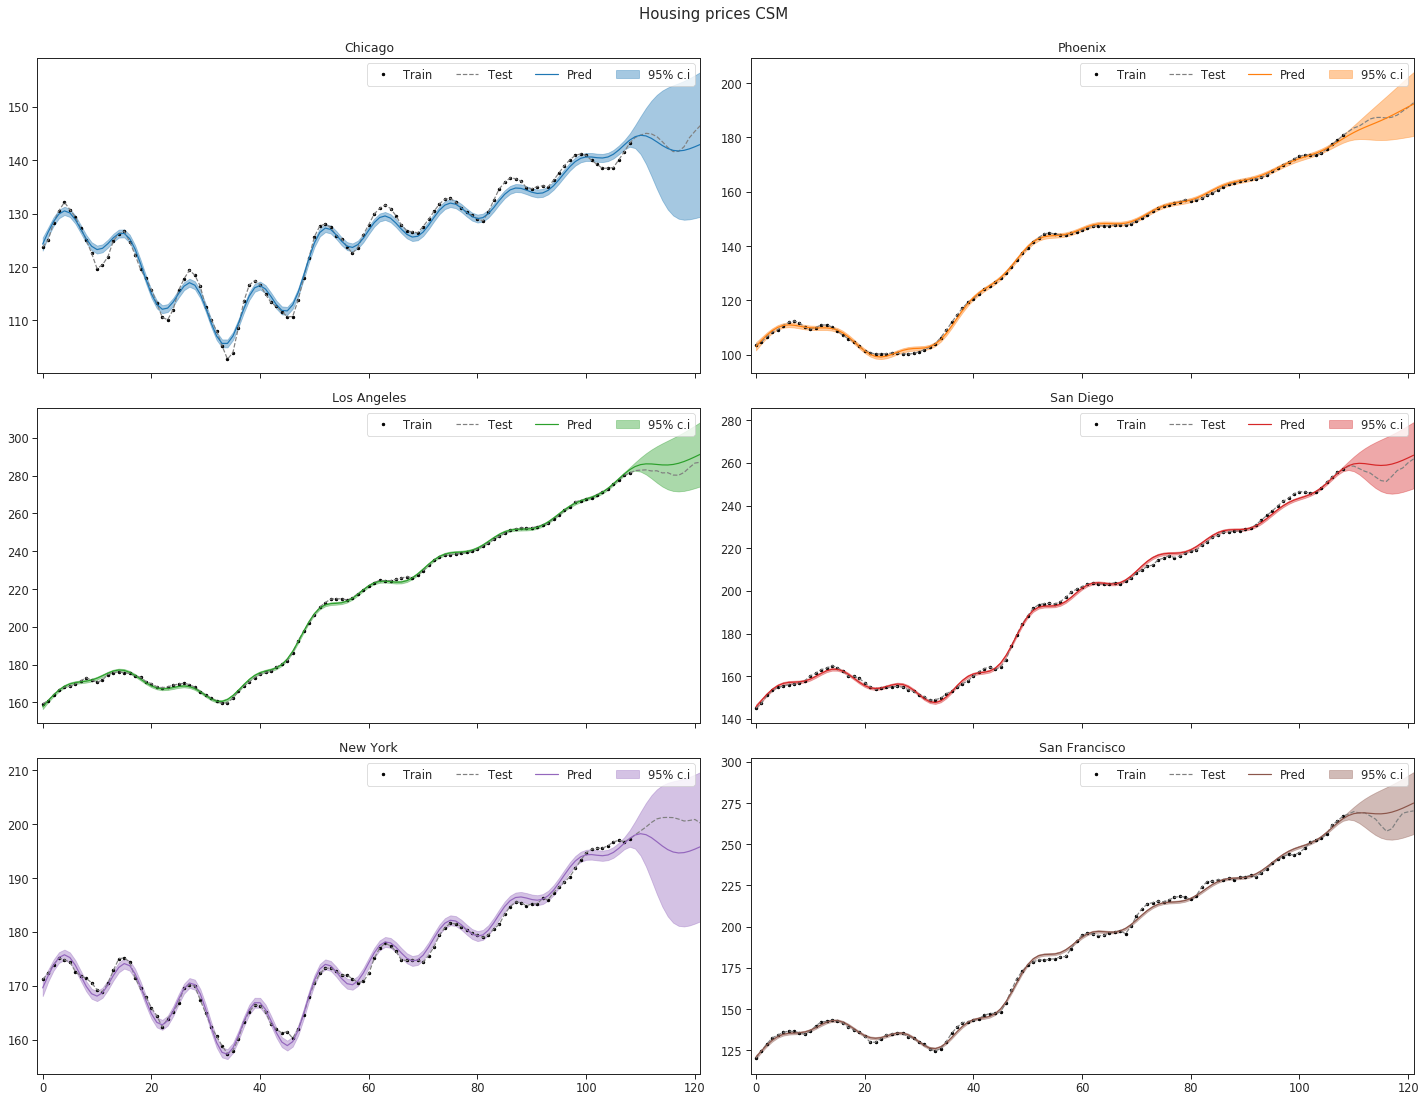

In [16]:
plot_experiment(model, names=cols, trends=trend_list, title='Housing prices CSM')

## SM LMC

In [19]:
n_trials = 10

smlmc_mae = np.zeros((n_trials, len(cols)))
smlmc_mape = np.zeros((n_trials, len(cols)))
smlmc_mse = np.zeros((n_trials, len(cols)))

for n in range(n_trials):
    print('Trial ', n)
    model = mogptk.SM_LMC(data, Q=3)
    # model.init_params()
    
    model.train(method='L-BFGS-B', maxiter=3000, tol=1e-50)
    
    mae, mape, mse = test_errors(model)
    
    smlmc_mae[n, :] = mae
    smlmc_mape[n, :] = mape
    smlmc_mse[n, :] = mse

pd.DataFrame(np.c_[smlmc_mae.mean(0), smlmc_mape.mean(0), smlmc_mse.mean(0),
                   smlmc_mae.std(0), smlmc_mape.std(0), smlmc_mse.std(0)],
             columns=['MAE', 'MAPE%', 'MSE', 'MAE std', 'MAPE% std', 'MSE std'])

Trial  0
INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: 1213.080801
  Number of iterations: 582
  Number of functions evaluations: 669
Done in  0.8084580858548482  minutes
Trial  1
INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: 1213.080801
  Number of iterations: 490
  Number of functions evaluations: 565
Done in  0.7465115427970886  minutes
Trial  2
INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: 1214.383176
  Number of iterations: 702
  Number of functions evaluations: 786
Done in  0.8880207339922587  minutes
Trial  3
INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: 1213.080801
  Number of iterations: 652
  Number of functions evaluations: 746
Done in  0.8604739983876546  minutes
Trial  4
INFO:tensorflow

,MAE,MAPE%,MSE,MAE std,MAPE% std,MSE std
0,1.022901,0.445136,2.640146,0.031325,0.013657,0.065128
1,1.937523,0.990081,4.198746,0.038415,0.018809,0.172439
2,3.833837,2.219187,16.110519,0.112362,0.071636,0.893982
3,3.727774,2.982730,19.847084,0.110806,0.098079,0.968604
4,3.355634,0.548895,14.733802,0.120024,0.017593,0.804525
5,3.850753,0.991611,26.584110,0.098673,0.027295,0.885764


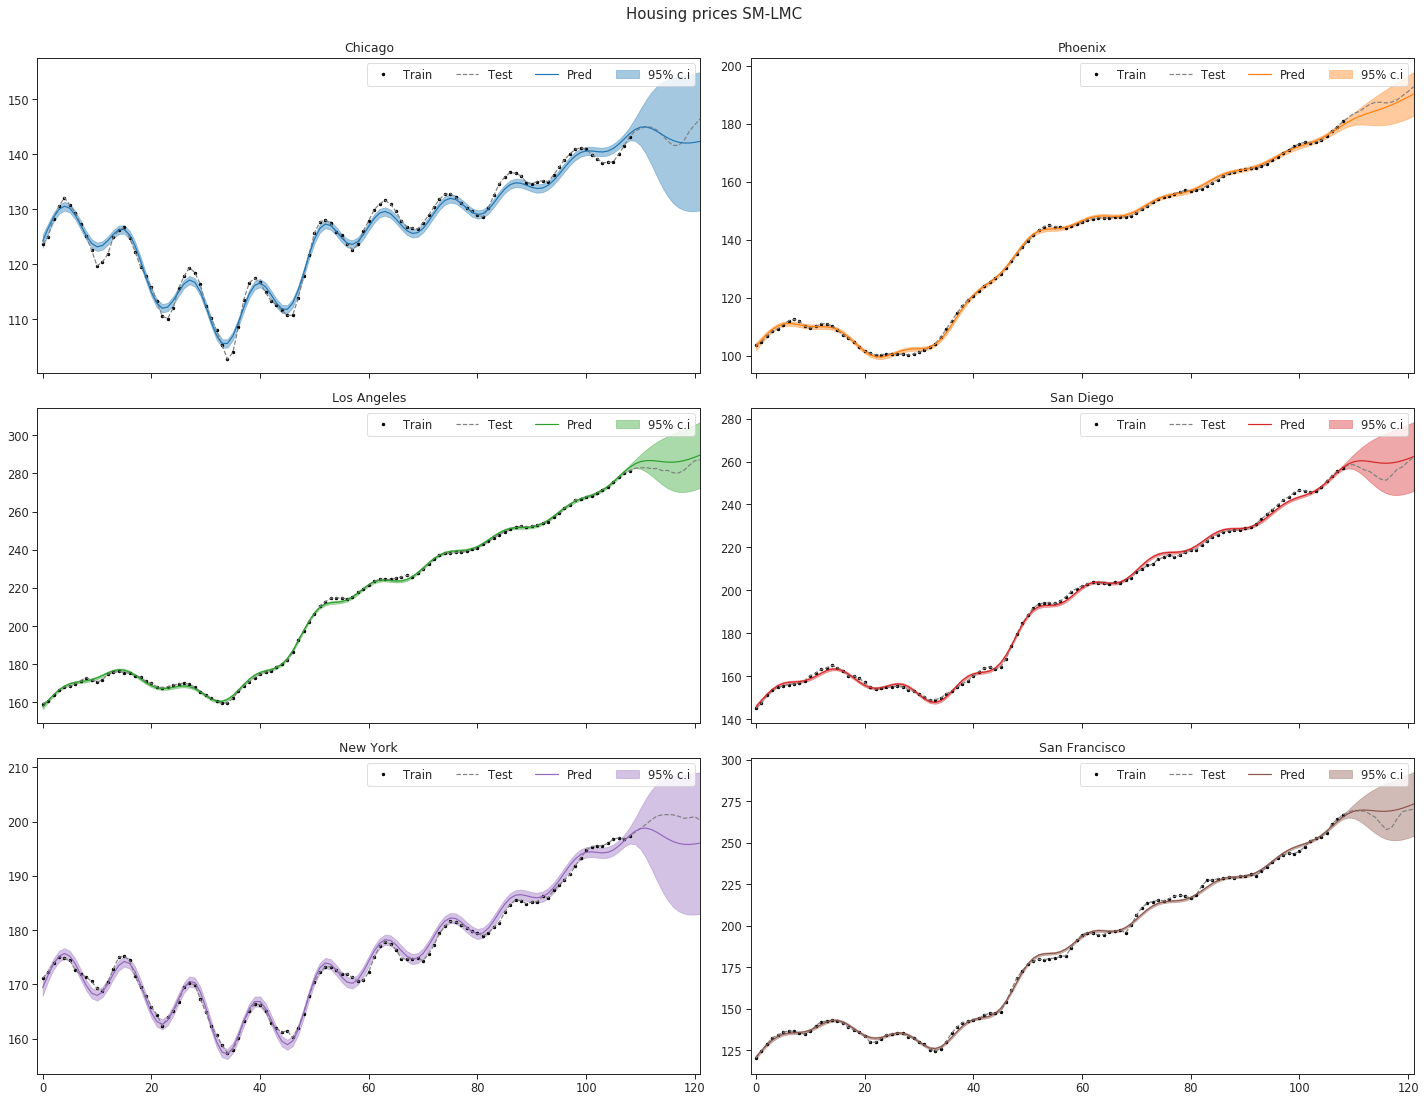

In [20]:
plot_experiment(model, names=cols, trends=trend_list, title='Housing prices SM-LMC')

In [28]:
print(mosm_mape.mean(), csm_mape.mean(), smlmc_mape.mean())

2.808751297539783 1.4915383606358683 1.3629400138467773
